In [25]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
import itertools
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve,auc, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [26]:
# Set GPU memory growth on

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [27]:

from google.colab import drive
drive.mount('/content/drive/')

test_dir = "drive/MyDrive/AI_project/AI_test"
test_dir = pathlib.Path(test_dir)

load_dir = "drive/MyDrive/AI_project/Models"
load_dir = pathlib.Path(load_dir)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
image_count = len(list(test_dir.glob('*/*.png')))
print(image_count)

1704


In [29]:
# Load the model
model_load_name = 'classifier_final_cnn_3_layers.pt'
path = os.path.join(load_dir,model_load_name)

model = tf.keras.models.load_model(path)

model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 32) 896         rescaling[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 200, 200, 32) 0           conv2d[0][0]                     
______________________________________________________________________________________________

### Create a dataset

In [30]:
test_names = os.listdir("/content/drive/My Drive/AI_project/AI_test")
test_names 

['Noisy', 'Normal', 'Other', 'AF']

In [31]:
batch_size = 32
img_width = 200
img_height = 200
classes = ['N', 'A', 'O', '~']

In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0,
  seed=123,
  image_size=(img_width,img_height),
  batch_size=batch_size)


Found 1704 files belonging to 4 classes.


In [33]:
class_names_t = test_ds.class_names
print(class_names_t)


['AF', 'Noisy', 'Normal', 'Other']


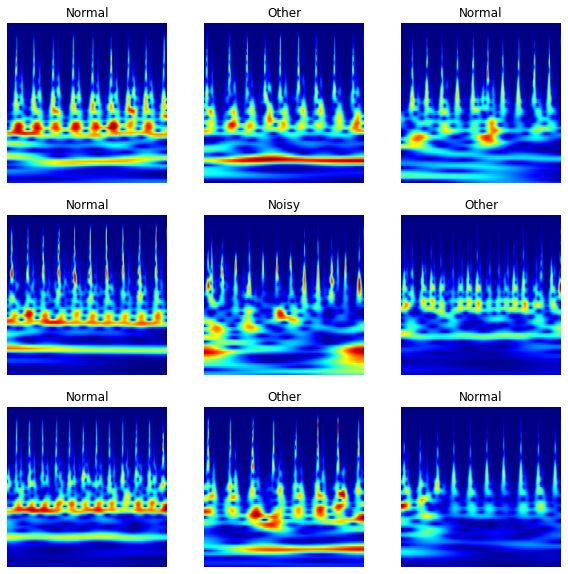

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_t[labels[i]])
    plt.axis("off")
plt.show()

### Standardize the data


In [35]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# normalize the data
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))



In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# test labels
test_labels = np.concatenate([y for x,y in test_ds],axis=0)
test_labels_count = Counter(test_labels)
test_labels_count

Counter({0: 147, 1: 56, 2: 1010, 3: 491})

In [38]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

# predict using the test set
predictions_t = model.predict(test_ds)
pred_per_t = probability_model.predict(test_ds)
max_t = np.argmax(predictions_t,axis=1)


In [39]:
print(test_labels.shape)
print(predictions_t)

(1704,)
[[-0.7073397  -2.106401    3.882703    2.8059804 ]
 [-0.98898596 -0.38429916  2.5492647   1.7007289 ]
 [-1.7678853   0.39718792  2.736507    1.4793222 ]
 ...
 [-0.82444453 -2.480164    4.284503    3.0477262 ]
 [-0.2350104  -0.5177531   1.8439355   0.8742466 ]
 [-0.8603034  -1.6350492   3.7666984   2.4724674 ]]


In [40]:
# Confusion matrix
cf_t = tf.math.confusion_matrix(
    test_labels, max_t, num_classes=4, weights=None, dtype=tf.dtypes.int32,
    name=None
)

In [41]:
def plot_confusion_matrix(cm, class_names,title="Confusion Matrix"):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  fig,ax = plt.subplots(figsize=(8,7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar(im,ax=ax)
  ax.set_aspect('auto')
  plt.title(title)
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return fig

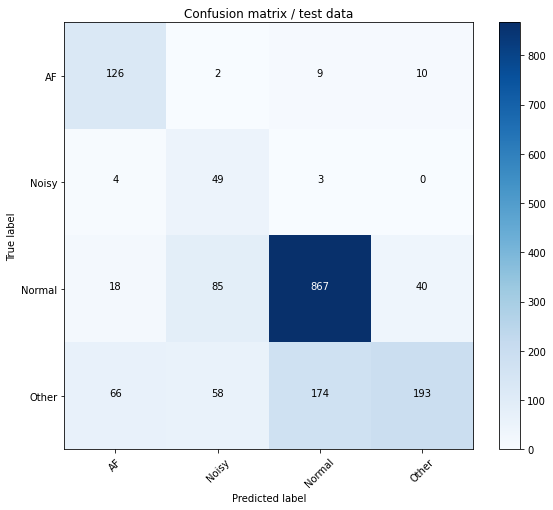

In [42]:
cf_fig_t = plot_confusion_matrix(cf_t.numpy(), class_names_t, "Confusion matrix / test data")
cf_fig_t.show()

In [43]:
def plot_multiclass_roc(X_test, y_test, label, n_classes, figsize=(17, 6)):
    y_score = probability_model.predict(X_test)


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Multilabel ROC / test data')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],label[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


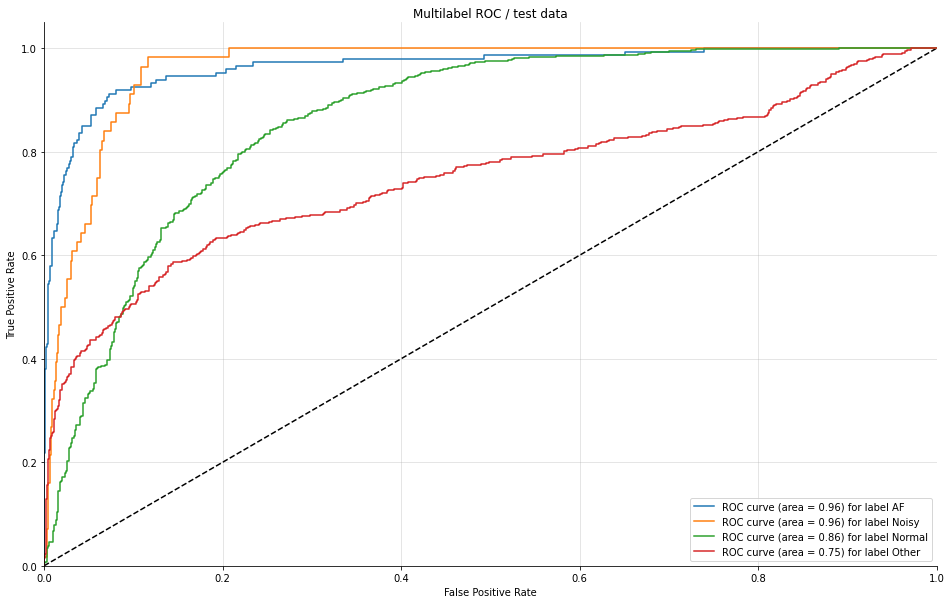

In [44]:
# test data
plot_multiclass_roc(test_ds, test_labels, class_names_t, n_classes=4, figsize=(16, 10))

In [45]:
print(classification_report(test_labels, max_t, target_names=class_names_t))

              precision    recall  f1-score   support

          AF       0.59      0.86      0.70       147
       Noisy       0.25      0.88      0.39        56
      Normal       0.82      0.86      0.84      1010
       Other       0.79      0.39      0.53       491

    accuracy                           0.72      1704
   macro avg       0.61      0.75      0.61      1704
weighted avg       0.78      0.72      0.72      1704



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


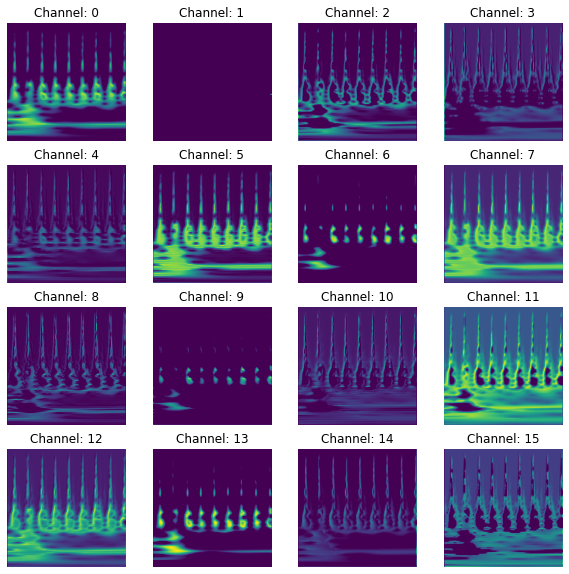

In [46]:
model_2 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[2].output)
model_2.summary()
image_tf = test_ds.take(1)
feature_maps = model_2.predict(image_tf)

n_filters = 16

fig, ax = plt.subplots(figsize=(10,10))

for i in range(n_filters):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(feature_maps[0][:,:,i])
  plt.title("Channel: {}".format(i))
  plt.axis('off')
plt.show()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 200, 200, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 200, 200, 32)      0   

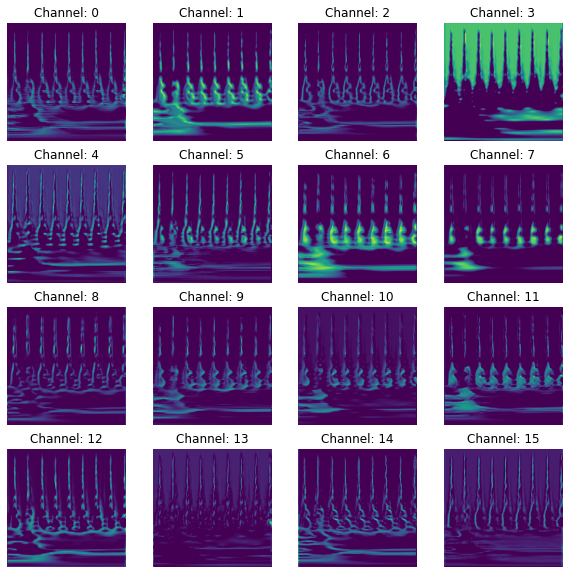

In [47]:
model_3 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[6].output)
model_3.summary()
image_tf = test_ds.take(1)
feature_maps_2 = model_3.predict(image_tf)

n_filters = 16

fig, ax = plt.subplots(figsize=(10,10))

for i in range(n_filters):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(feature_maps_2[0][:,:,i])
  plt.title("Channel: {}".format(i))
  plt.axis('off')
plt.show()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 200, 200, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 200, 200, 32)      0   

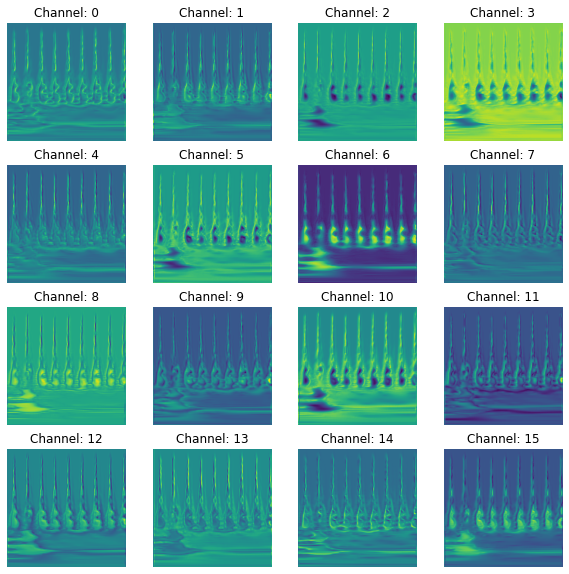

In [48]:
model_3 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[10].output)
model_3.summary()
image_tf = test_ds.take(1)
feature_maps_3 = model_3.predict(image_tf)

n_filters = 16

fig, ax = plt.subplots(figsize=(10,10))

for i in range(n_filters):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(feature_maps_3[0][:,:,i])
  plt.title("Channel: {}".format(i))
  plt.axis('off')
plt.show()